# Geos-Chem analysis

In [27]:
from __future__ import print_function

from ipywidgets import interact, SelectionSlider, IntSlider, Dropdown
from temp.gamap_colormap import WhGrYlRd
from math import ceil
import matplotlib.pyplot as plt
import ipywidgets as widgets
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import warnings
import xbpch

warnings.filterwarnings("ignore")  # hide some xbpch warnings

In [2]:
%matplotlib inline

## Global variables

In [3]:
# Files path
ARGS = {
    "trac_bpch": "temp/geos45s/trac_avg.geosfp_4x5_standard.201501010000",
    "trac_nc": "temp/geos45s/trac_avg.geosfp_4x5_standard.201501010000.nc",
    "tracerinfo": "temp/geos45s/tracerinfo.dat",
    "diaginfo": "temp/geos45s/diaginfo.dat",
    "fw_out": lambda x, l: f"out/img/{x}_cartopy_lev_{l}.png",
    "f_out": lambda x, l: f"out/img/{x}_lev_{l}.png",
}

## Functions

Get value size array

In [4]:
def rlen(variable):
    return range(len(variable))

Plot with cartography

In [25]:
def plot_cartopy(emiss, tracers: [str], times: [int], levs: [int]):
    emissions = emiss[tracers]
    time_size = len(times)
    times = [t.values.astype("datetime64[M]") for t in emissions["time"]]
    
    for emission in emissions.values():
        print(f"TRACER {emission.attrs['name']}")
        
        for l in levs:
            print(f"LEV {l}")
            
            fig, axes = plt.subplots(
                ceil(time_size/2),
                1 if time_size == 1 else 2,
                figsize=(15, 5),
                subplot_kw={"projection": ccrs.PlateCarree()}
            )

            # Plot BPCH diagnotics for each time
            for ax, t in zip(axes, times):
                emission.isel(time=t, lev=l).plot(
                    ax=ax,
                    cmap=WhGrYlRd,
                    vmin=0,
                    cbar_kwargs={"shrink": 0.5, "label": "ppbv"},
                )
                ax.set_title(f"{emission.attrs['name']} lev {l} - {times[t]}")
                ax.coastlines()
                ax.gridlines(linestyle="--")

#             plt.savefig(ARGS["fw_out"](emission.attrs["name"], 0))

Plot without cartography

In [26]:
def plot(emiss, tracers: [str], times: [int], levs: [int]):
    emissions = emiss[tracers]
    time_size = len(times)

    for emission in emissions.values():
        print(f"TRACER {emission.attrs['name']}")
        
        for l in levs:
            print(f"LEV {l}")
            
            fig, axes = plt.subplots(
                ceil(time_size/2),
                1 if time_size == 1 else 2,
                figsize=(15, 5)
            )

            # Plot BPCH diagnotics for each time
            for ax, t in zip(axes, rlen(times)):
                emission.isel(time=t, lev=l).plot(ax=ax, cmap=WhGrYlRd, vmin=0)

    #         plt.savefig(ARGS["f_out"](emission.attrs["name"], 0))

## Analysis

Open binary diagnostic with .dat (contain tracer names and other metadata)

In [59]:
df_trac = xbpch.open_bpchdataset(
    ARGS["trac_bpch"],
    tracerinfo_file=ARGS["tracerinfo"],
    diaginfo_file=ARGS["diaginfo"],
)
df_trac

<xarray.Dataset>
Dimensions:            (lat: 46, lev: 72, lev_edge: 73, lon: 72, nv: 2, time: 2)
Coordinates:
  * lev                (lev) float64 0.9925 0.9775 ... 1.614e-05 4.935e-06
  * lon                (lon) float64 -180.0 -175.0 -170.0 ... 165.0 170.0 175.0
  * lat                (lat) float64 -89.0 -86.0 -82.0 -78.0 ... 82.0 86.0 89.0
  * time               (time) datetime64[ns] 2015-01-01 2015-02-01
  * nv                 (nv) int64 0 1
Dimensions without coordinates: lev_edge
Data variables:
    PL_SUL_S_SO2dms    (time, lon, lat, lev) float32 dask.array<chunksize=(1, 72, 46, 72), meta=np.ndarray>
    time_bnds          (time, nv) datetime64[ns] 2015-01-01 ... 2015-03-01
    PL_SUL_S_SO2no3    (time, lon, lat, lev) float32 dask.array<chunksize=(1, 72, 46, 72), meta=np.ndarray>
    PL_SUL_S_SO2tot    (time, lon, lat, lev) float32 dask.array<chunksize=(1, 72, 46, 72), meta=np.ndarray>
    PL_SUL_S_MSAdms    (time, lon, lat, lev) float32 dask.array<chunksize=(1, 72, 46, 72), me

Select variable

In [6]:
df_trac["IJ_AVG_S_CO"]

<xarray.DataArray 'IJ_AVG_S_CO' (time: 2, lon: 72, lat: 46, lev: 72)>
dask.array<mul, shape=(2, 72, 46, 72), dtype=float32, chunksize=(1, 72, 46, 72), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 0.9925 0.9775 0.9624 ... 1.614e-05 4.935e-06
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 165.0 170.0 175.0
  * lat      (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 89.0
  * time     (time) datetime64[ns] 2015-01-01 2015-02-01
Attributes:
    number:          4
    category:        IJ-AVG-$
    name:            CO
    full_name:       CO tracer
    molwt:           0.028
    C:               1
    tracer:          4
    hydrocarbon:     False
    chemical:        True
    original_shape:  (72, 46, 72)
    origin:          (1, 1, 1)
    scale_factor:    1000000000.0
    units:           ppbv

Select time boundaries

In [7]:
df_trac["time_bnds"]

<xarray.DataArray 'time_bnds' (time: 2, nv: 2)>
array([['2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000'],
       ['2015-02-01T00:00:00.000000000', '2015-03-01T00:00:00.000000000']],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-02-01
  * nv       (nv) int64 0 1
Attributes:
    units:    hours since 1985-01-01 00:00:00

Drop time boundaries and redudant dimension

In [62]:
df_trac = df_trac.drop("time_bnds")
df_trac = df_trac.drop("nv")

Changes order (time, lon, lat, lev) to common order (time, lev, lat, lon)

In [9]:
# df_trac = df_trac.transpose("time", "lev", "lat", "lon")
# df_trac

Convert BPCH data to NC format

In [10]:
# df_trac = xbpch.common.fix_attr_encoding(df_trac)
# df_trac.to_netcdf(ARGS["trac_nc"])

Terminal command

In [11]:
# !ncdump -h temp/geos45s/trac_avg.geosfp_4x5_standard.201501010000.nc

Open NC

In [12]:
# ds_nc = xr.open_dataset("trac.nc")
# ds_nc

## Plot interactive

In [68]:
tracers = list(df_trac.data_vars)
tracers.sort()

interactive(children=(Dropdown(description='tracer', options=('ACETSRCE_ACETbg', 'ACETSRCE_ACETmb', 'ACETSRCE_…

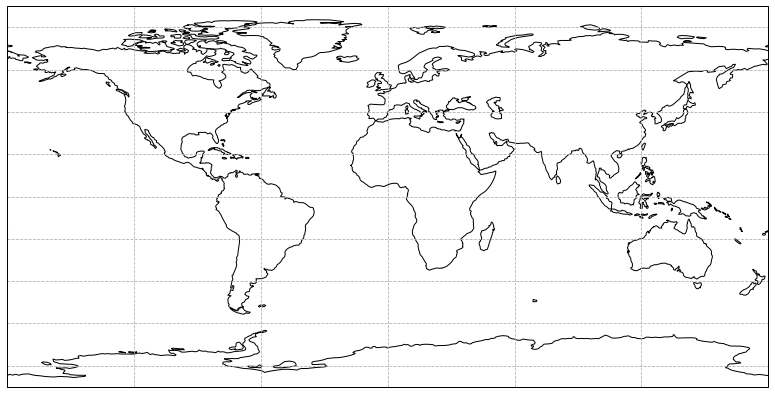

In [69]:
@interact(
    tracer=Dropdown(options=tracers, continuous_update=False), 
    lev=IntSlider(min=0, max=46, step=1, continuous_update=False),
)
def plot_layer(tracer, lev):
    try:
        _ = plt.figure(figsize=[16, 7])
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines()
        ax.gridlines(linestyle="--")

        df_trac[tracer].isel(time=0, lev=lev).plot(ax=ax, cmap=WhGrYlRd)
        ax.set_title(tracer + f"; lev={lev}")
    except Exception as e:
        print(f"{e}")

In [19]:
# @interact(var=SelectionSlider(options=varnames, continuous_update=False))
# def plot_zonal_mean(var):
#     ds[var].mean(dim=['lon']).plot(cmap=WhGrYlRd)
#     plt.title(var+'; zonal mean')